# Pytorh Variational Auto Encoder (MNIST Dataset)

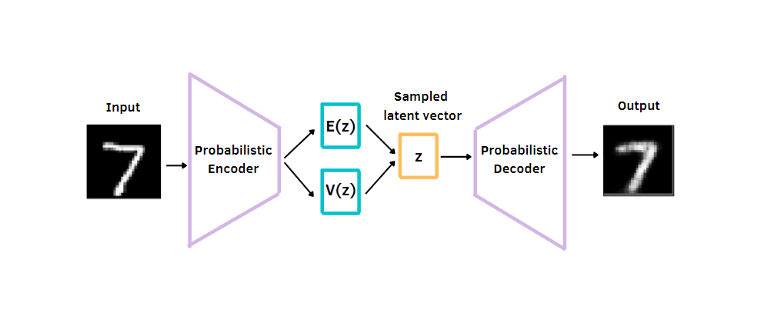

In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## Encoder

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z      

## Decoder

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

## VAE Model

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

In [ ]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [ ]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [ ]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

## Training Loop

	 partial train loss (single batch): 69609.750000
	 partial train loss (single batch): 67573.000000
	 partial train loss (single batch): 66205.765625
	 partial train loss (single batch): 64562.210938
	 partial train loss (single batch): 63221.695312
	 partial train loss (single batch): 62286.742188
	 partial train loss (single batch): 61533.527344
	 partial train loss (single batch): 60934.933594
	 partial train loss (single batch): 60152.144531
	 partial train loss (single batch): 59436.816406
	 partial train loss (single batch): 58652.238281
	 partial train loss (single batch): 58234.812500
	 partial train loss (single batch): 57826.363281
	 partial train loss (single batch): 57339.675781
	 partial train loss (single batch): 56853.324219
	 partial train loss (single batch): 56540.894531
	 partial train loss (single batch): 56073.722656
	 partial train loss (single batch): 55254.839844
	 partial train loss (single batch): 54967.789062
	 partial train loss (single batch): 54605.097656


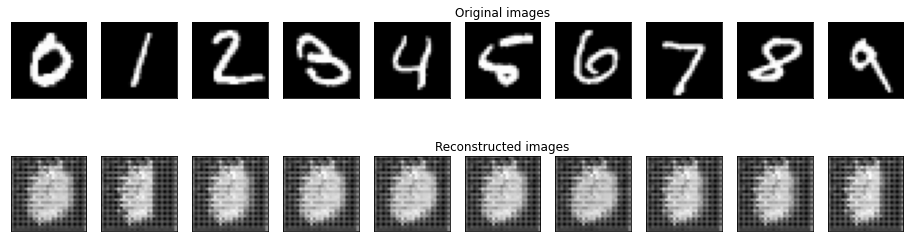

	 partial train loss (single batch): 19606.955078
	 partial train loss (single batch): 19883.951172
	 partial train loss (single batch): 19712.894531
	 partial train loss (single batch): 19628.656250
	 partial train loss (single batch): 19559.332031
	 partial train loss (single batch): 19611.908203
	 partial train loss (single batch): 19279.304688
	 partial train loss (single batch): 19142.982422
	 partial train loss (single batch): 19127.835938
	 partial train loss (single batch): 19276.255859
	 partial train loss (single batch): 19221.593750
	 partial train loss (single batch): 19025.222656
	 partial train loss (single batch): 18962.294922
	 partial train loss (single batch): 18946.933594
	 partial train loss (single batch): 18991.457031
	 partial train loss (single batch): 18668.482422
	 partial train loss (single batch): 18670.169922
	 partial train loss (single batch): 18839.621094
	 partial train loss (single batch): 18712.736328
	 partial train loss (single batch): 18573.312500


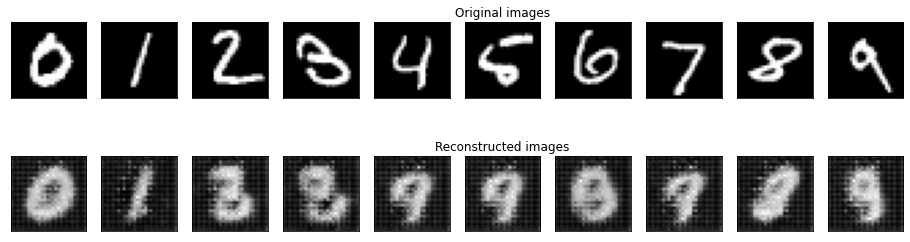

	 partial train loss (single batch): 13095.114258
	 partial train loss (single batch): 13531.114258
	 partial train loss (single batch): 13282.587891
	 partial train loss (single batch): 13247.238281
	 partial train loss (single batch): 13286.163086
	 partial train loss (single batch): 13316.801758
	 partial train loss (single batch): 13108.929688
	 partial train loss (single batch): 12983.126953
	 partial train loss (single batch): 12931.481445
	 partial train loss (single batch): 13075.722656
	 partial train loss (single batch): 13178.223633
	 partial train loss (single batch): 13089.997070
	 partial train loss (single batch): 13005.963867
	 partial train loss (single batch): 13138.357422
	 partial train loss (single batch): 13314.060547
	 partial train loss (single batch): 12800.008789
	 partial train loss (single batch): 12928.154297
	 partial train loss (single batch): 13225.683594
	 partial train loss (single batch): 13267.011719
	 partial train loss (single batch): 13034.842773


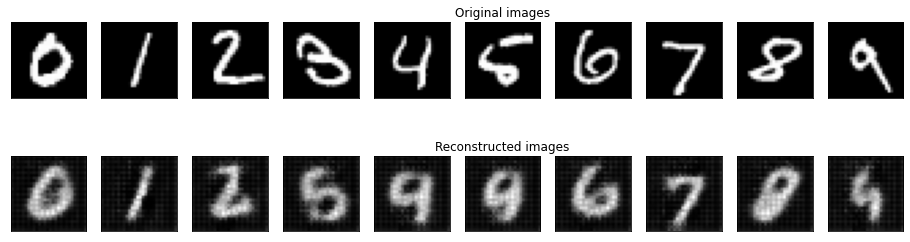

	 partial train loss (single batch): 10533.548828
	 partial train loss (single batch): 10831.087891
	 partial train loss (single batch): 10696.257812
	 partial train loss (single batch): 10693.408203
	 partial train loss (single batch): 10616.041016
	 partial train loss (single batch): 10705.533203
	 partial train loss (single batch): 10706.802734
	 partial train loss (single batch): 10523.265625
	 partial train loss (single batch): 10605.583984
	 partial train loss (single batch): 10525.197266
	 partial train loss (single batch): 10843.240234
	 partial train loss (single batch): 10671.617188
	 partial train loss (single batch): 10461.894531
	 partial train loss (single batch): 10768.785156
	 partial train loss (single batch): 10922.413086
	 partial train loss (single batch): 10305.058594
	 partial train loss (single batch): 10654.000000
	 partial train loss (single batch): 10865.056641
	 partial train loss (single batch): 10814.627930
	 partial train loss (single batch): 10692.363281


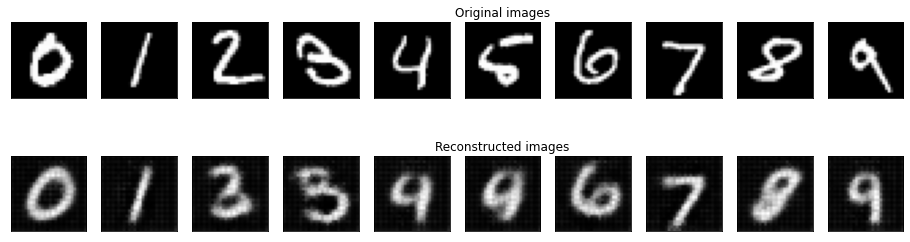

	 partial train loss (single batch): 9580.843750
	 partial train loss (single batch): 9840.590820
	 partial train loss (single batch): 9548.145508
	 partial train loss (single batch): 9693.310547
	 partial train loss (single batch): 9563.493164
	 partial train loss (single batch): 9759.180664
	 partial train loss (single batch): 9847.882812
	 partial train loss (single batch): 9570.486328
	 partial train loss (single batch): 9632.914062
	 partial train loss (single batch): 9588.534180
	 partial train loss (single batch): 9943.003906
	 partial train loss (single batch): 9764.216797
	 partial train loss (single batch): 9559.930664
	 partial train loss (single batch): 9936.035156
	 partial train loss (single batch): 10013.866211
	 partial train loss (single batch): 9360.014648
	 partial train loss (single batch): 9601.029297
	 partial train loss (single batch): 9817.613281
	 partial train loss (single batch): 10011.054688
	 partial train loss (single batch): 9950.522461
	 partial train lo

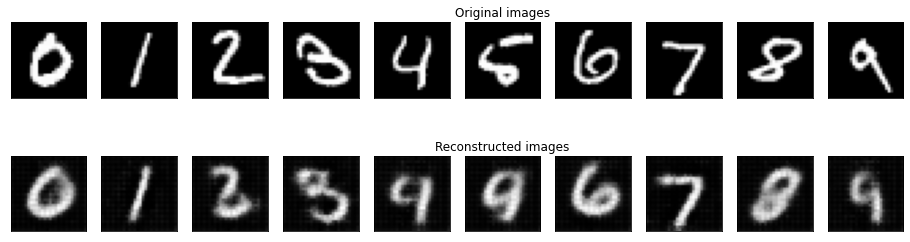

	 partial train loss (single batch): 9152.812500
	 partial train loss (single batch): 9470.714844
	 partial train loss (single batch): 9292.263672
	 partial train loss (single batch): 9317.060547
	 partial train loss (single batch): 9195.987305
	 partial train loss (single batch): 9331.527344
	 partial train loss (single batch): 9526.921875
	 partial train loss (single batch): 9212.668945
	 partial train loss (single batch): 9336.508789
	 partial train loss (single batch): 9097.894531
	 partial train loss (single batch): 9587.949219
	 partial train loss (single batch): 9426.059570
	 partial train loss (single batch): 9206.943359
	 partial train loss (single batch): 9536.906250
	 partial train loss (single batch): 9668.167969
	 partial train loss (single batch): 8983.027344
	 partial train loss (single batch): 9247.644531
	 partial train loss (single batch): 9446.525391
	 partial train loss (single batch): 9602.057617
	 partial train loss (single batch): 9558.564453
	 partial train loss

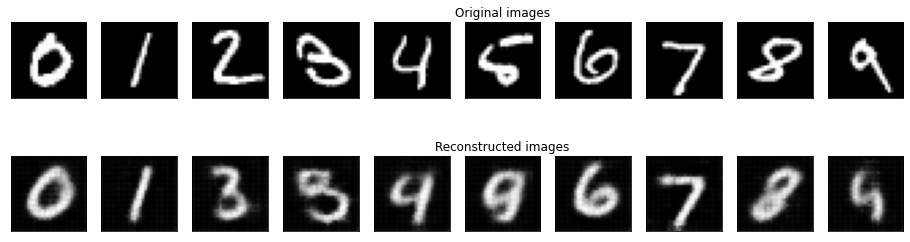

	 partial train loss (single batch): 8974.302734
	 partial train loss (single batch): 9240.876953
	 partial train loss (single batch): 8984.974609
	 partial train loss (single batch): 9088.082031
	 partial train loss (single batch): 8956.068359
	 partial train loss (single batch): 9172.014648
	 partial train loss (single batch): 9219.042969
	 partial train loss (single batch): 9025.627930
	 partial train loss (single batch): 9083.782227
	 partial train loss (single batch): 8912.227539
	 partial train loss (single batch): 9366.222656
	 partial train loss (single batch): 9210.994141
	 partial train loss (single batch): 9017.586914
	 partial train loss (single batch): 9355.292969
	 partial train loss (single batch): 9435.593750
	 partial train loss (single batch): 8760.527344
	 partial train loss (single batch): 9036.868164
	 partial train loss (single batch): 9234.266602
	 partial train loss (single batch): 9379.228516
	 partial train loss (single batch): 9295.585938
	 partial train loss

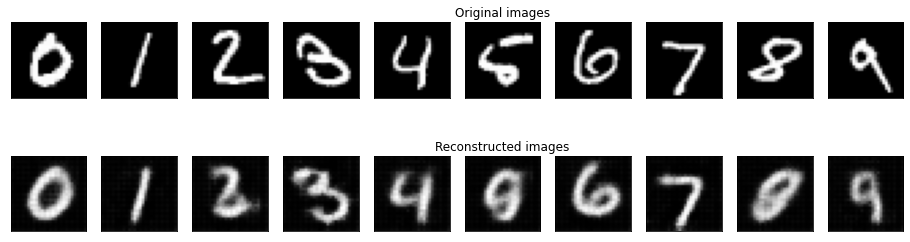

	 partial train loss (single batch): 8792.001953
	 partial train loss (single batch): 9122.386719
	 partial train loss (single batch): 8857.748047
	 partial train loss (single batch): 8935.035156
	 partial train loss (single batch): 8870.693359
	 partial train loss (single batch): 9009.511719
	 partial train loss (single batch): 9065.601562
	 partial train loss (single batch): 8841.490234
	 partial train loss (single batch): 9037.262695
	 partial train loss (single batch): 8856.375000
	 partial train loss (single batch): 9287.765625
	 partial train loss (single batch): 9113.568359
	 partial train loss (single batch): 8916.357422
	 partial train loss (single batch): 9170.190430
	 partial train loss (single batch): 9325.923828
	 partial train loss (single batch): 8567.525391
	 partial train loss (single batch): 8890.433594
	 partial train loss (single batch): 9098.157227
	 partial train loss (single batch): 9330.941406
	 partial train loss (single batch): 9227.462891
	 partial train loss

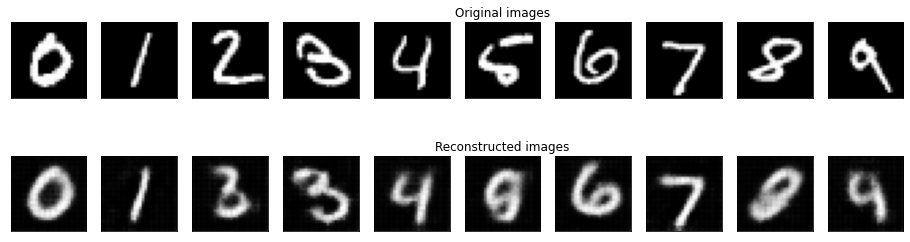

	 partial train loss (single batch): 8713.089844
	 partial train loss (single batch): 9040.201172
	 partial train loss (single batch): 8811.003906
	 partial train loss (single batch): 8982.962891
	 partial train loss (single batch): 8746.049805
	 partial train loss (single batch): 8866.131836
	 partial train loss (single batch): 8982.597656
	 partial train loss (single batch): 8697.115234
	 partial train loss (single batch): 8838.765625
	 partial train loss (single batch): 8810.100586
	 partial train loss (single batch): 9171.349609
	 partial train loss (single batch): 8974.111328
	 partial train loss (single batch): 8726.840820
	 partial train loss (single batch): 9068.208984
	 partial train loss (single batch): 9162.987305
	 partial train loss (single batch): 8407.761719
	 partial train loss (single batch): 8744.765625
	 partial train loss (single batch): 9045.494141
	 partial train loss (single batch): 9210.516602
	 partial train loss (single batch): 9096.160156
	 partial train loss

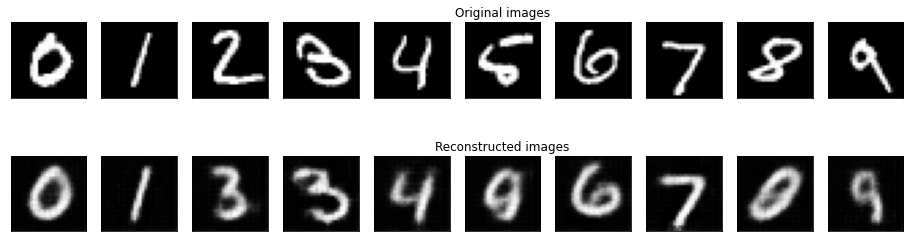

	 partial train loss (single batch): 8675.027344
	 partial train loss (single batch): 8939.418945
	 partial train loss (single batch): 8706.125977
	 partial train loss (single batch): 8785.148438
	 partial train loss (single batch): 8619.234375
	 partial train loss (single batch): 8838.765625
	 partial train loss (single batch): 9043.170898
	 partial train loss (single batch): 8614.868164
	 partial train loss (single batch): 8776.611328
	 partial train loss (single batch): 8755.317383
	 partial train loss (single batch): 9164.757812
	 partial train loss (single batch): 8974.928711
	 partial train loss (single batch): 8729.714844
	 partial train loss (single batch): 9024.125000
	 partial train loss (single batch): 9206.501953
	 partial train loss (single batch): 8391.013672
	 partial train loss (single batch): 8681.698242
	 partial train loss (single batch): 8976.689453
	 partial train loss (single batch): 9167.256836
	 partial train loss (single batch): 9048.006836
	 partial train loss

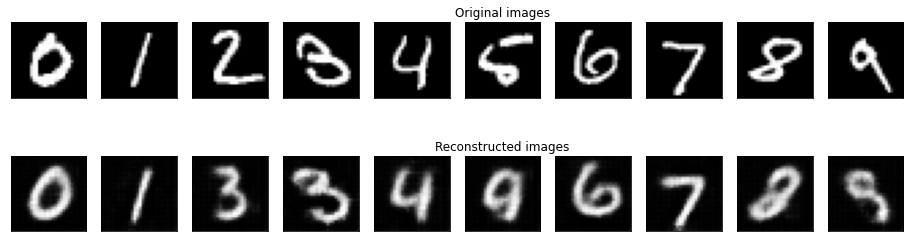

	 partial train loss (single batch): 8668.495117
	 partial train loss (single batch): 8911.666016
	 partial train loss (single batch): 8560.944336
	 partial train loss (single batch): 8795.509766
	 partial train loss (single batch): 8618.162109
	 partial train loss (single batch): 8809.960938
	 partial train loss (single batch): 8823.609375
	 partial train loss (single batch): 8565.376953
	 partial train loss (single batch): 8708.861328
	 partial train loss (single batch): 8578.946289
	 partial train loss (single batch): 8986.755859
	 partial train loss (single batch): 8803.583984
	 partial train loss (single batch): 8722.056641
	 partial train loss (single batch): 8935.613281
	 partial train loss (single batch): 9151.189453
	 partial train loss (single batch): 8362.343750
	 partial train loss (single batch): 8575.473633
	 partial train loss (single batch): 9001.434570
	 partial train loss (single batch): 9082.104492
	 partial train loss (single batch): 9013.962891
	 partial train loss

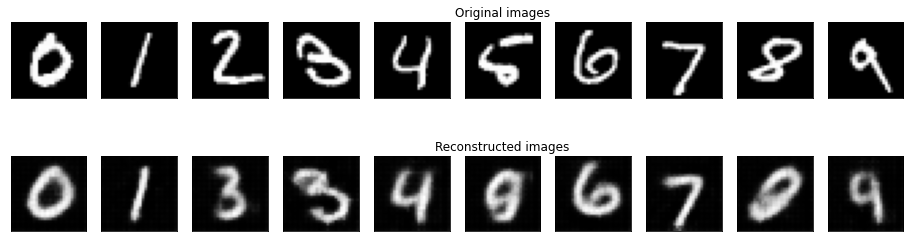

	 partial train loss (single batch): 8565.765625
	 partial train loss (single batch): 8770.501953
	 partial train loss (single batch): 8564.513672
	 partial train loss (single batch): 8706.708008
	 partial train loss (single batch): 8555.386719
	 partial train loss (single batch): 8696.214844
	 partial train loss (single batch): 8823.576172
	 partial train loss (single batch): 8517.703125
	 partial train loss (single batch): 8630.829102
	 partial train loss (single batch): 8665.398438
	 partial train loss (single batch): 9037.125000
	 partial train loss (single batch): 8795.350586
	 partial train loss (single batch): 8593.337891
	 partial train loss (single batch): 8912.423828
	 partial train loss (single batch): 9084.748047
	 partial train loss (single batch): 8255.219727
	 partial train loss (single batch): 8583.713867
	 partial train loss (single batch): 8988.858398
	 partial train loss (single batch): 8990.819336
	 partial train loss (single batch): 8935.310547
	 partial train loss

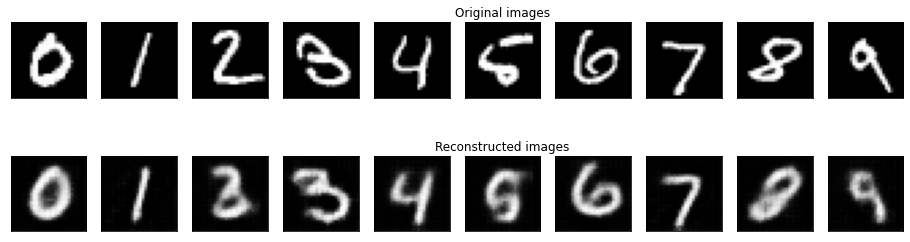

	 partial train loss (single batch): 8530.203125
	 partial train loss (single batch): 8733.173828
	 partial train loss (single batch): 8560.713867
	 partial train loss (single batch): 8649.526367
	 partial train loss (single batch): 8444.944336
	 partial train loss (single batch): 8677.298828
	 partial train loss (single batch): 8753.037109
	 partial train loss (single batch): 8523.500000
	 partial train loss (single batch): 8642.200195
	 partial train loss (single batch): 8544.451172
	 partial train loss (single batch): 8913.919922
	 partial train loss (single batch): 8769.409180
	 partial train loss (single batch): 8560.597656
	 partial train loss (single batch): 8868.083984
	 partial train loss (single batch): 9015.871094
	 partial train loss (single batch): 8180.170898
	 partial train loss (single batch): 8463.032227
	 partial train loss (single batch): 8775.119141
	 partial train loss (single batch): 9044.994141
	 partial train loss (single batch): 8875.692383
	 partial train loss

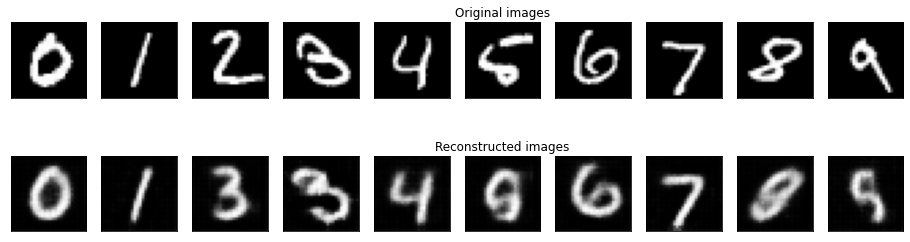

	 partial train loss (single batch): 8508.251953
	 partial train loss (single batch): 8761.267578
	 partial train loss (single batch): 8465.634766
	 partial train loss (single batch): 8611.958984
	 partial train loss (single batch): 8441.829102
	 partial train loss (single batch): 8716.501953
	 partial train loss (single batch): 8682.382812
	 partial train loss (single batch): 8468.164062
	 partial train loss (single batch): 8519.322266
	 partial train loss (single batch): 8568.843750
	 partial train loss (single batch): 8862.156250
	 partial train loss (single batch): 8711.138672
	 partial train loss (single batch): 8572.566406
	 partial train loss (single batch): 8871.917969
	 partial train loss (single batch): 9026.277344
	 partial train loss (single batch): 8246.574219
	 partial train loss (single batch): 8523.660156
	 partial train loss (single batch): 8780.213867
	 partial train loss (single batch): 8987.763672
	 partial train loss (single batch): 8807.031250
	 partial train loss

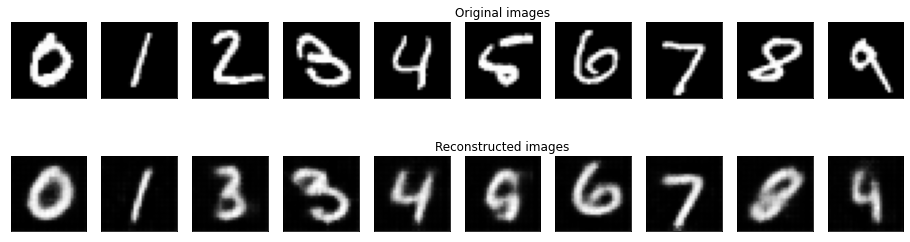

	 partial train loss (single batch): 8456.257812
	 partial train loss (single batch): 8758.372070
	 partial train loss (single batch): 8409.788086
	 partial train loss (single batch): 8615.747070
	 partial train loss (single batch): 8423.225586
	 partial train loss (single batch): 8685.771484
	 partial train loss (single batch): 8714.134766
	 partial train loss (single batch): 8333.244141
	 partial train loss (single batch): 8547.776367
	 partial train loss (single batch): 8428.413086
	 partial train loss (single batch): 8774.332031
	 partial train loss (single batch): 8674.802734
	 partial train loss (single batch): 8481.578125
	 partial train loss (single batch): 8723.941406
	 partial train loss (single batch): 8960.375000
	 partial train loss (single batch): 8194.263672
	 partial train loss (single batch): 8416.439453
	 partial train loss (single batch): 8709.507812
	 partial train loss (single batch): 8939.765625
	 partial train loss (single batch): 8771.082031
	 partial train loss

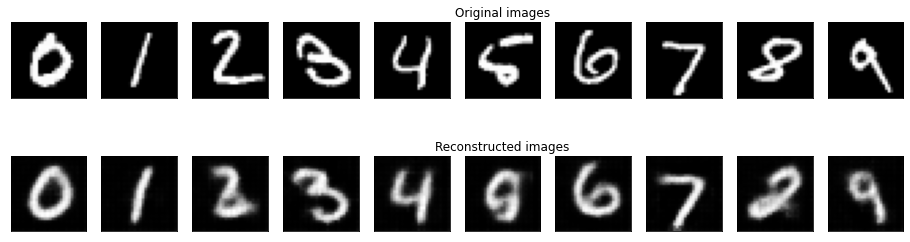

	 partial train loss (single batch): 8462.203125
	 partial train loss (single batch): 8596.990234
	 partial train loss (single batch): 8396.546875
	 partial train loss (single batch): 8583.230469
	 partial train loss (single batch): 8312.278320
	 partial train loss (single batch): 8646.718750
	 partial train loss (single batch): 8689.449219
	 partial train loss (single batch): 8380.036133
	 partial train loss (single batch): 8494.875977
	 partial train loss (single batch): 8469.011719
	 partial train loss (single batch): 8752.179688
	 partial train loss (single batch): 8677.764648
	 partial train loss (single batch): 8581.926758
	 partial train loss (single batch): 8859.726562
	 partial train loss (single batch): 8882.253906
	 partial train loss (single batch): 8166.484863
	 partial train loss (single batch): 8332.981445
	 partial train loss (single batch): 8706.902344
	 partial train loss (single batch): 8896.281250
	 partial train loss (single batch): 8747.616211
	 partial train loss

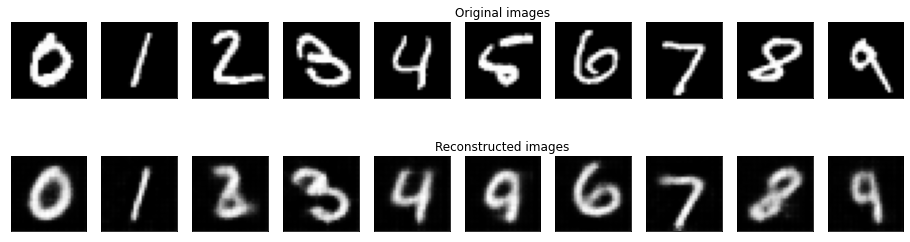

	 partial train loss (single batch): 8432.495117
	 partial train loss (single batch): 8582.755859
	 partial train loss (single batch): 8361.889648
	 partial train loss (single batch): 8547.715820
	 partial train loss (single batch): 8250.193359
	 partial train loss (single batch): 8468.595703
	 partial train loss (single batch): 8630.474609
	 partial train loss (single batch): 8357.612305
	 partial train loss (single batch): 8456.981445
	 partial train loss (single batch): 8455.878906
	 partial train loss (single batch): 8789.989258
	 partial train loss (single batch): 8659.140625
	 partial train loss (single batch): 8446.929688
	 partial train loss (single batch): 8769.652344
	 partial train loss (single batch): 8915.777344
	 partial train loss (single batch): 8051.894531
	 partial train loss (single batch): 8285.654297
	 partial train loss (single batch): 8661.052734
	 partial train loss (single batch): 8851.008789
	 partial train loss (single batch): 8759.485352
	 partial train loss

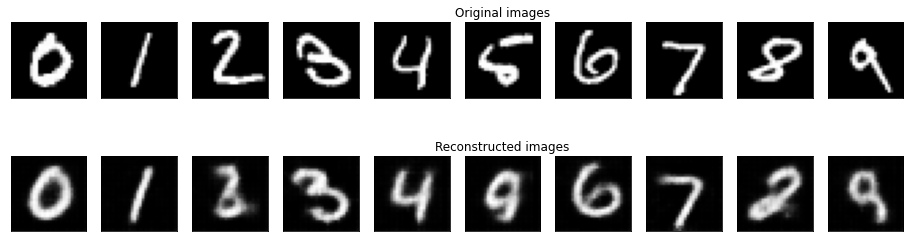

	 partial train loss (single batch): 8422.378906
	 partial train loss (single batch): 8611.212891
	 partial train loss (single batch): 8391.478516
	 partial train loss (single batch): 8442.343750
	 partial train loss (single batch): 8252.537109
	 partial train loss (single batch): 8620.743164
	 partial train loss (single batch): 8650.430664
	 partial train loss (single batch): 8193.215820
	 partial train loss (single batch): 8421.986328
	 partial train loss (single batch): 8362.345703
	 partial train loss (single batch): 8738.226562
	 partial train loss (single batch): 8624.364258
	 partial train loss (single batch): 8387.523438
	 partial train loss (single batch): 8672.208984
	 partial train loss (single batch): 8796.272461
	 partial train loss (single batch): 8048.388184
	 partial train loss (single batch): 8404.342773
	 partial train loss (single batch): 8643.298828
	 partial train loss (single batch): 8865.476562
	 partial train loss (single batch): 8751.215820
	 partial train loss

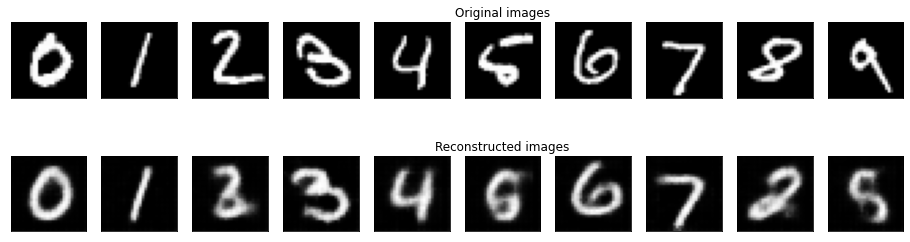

	 partial train loss (single batch): 8358.468750
	 partial train loss (single batch): 8548.701172
	 partial train loss (single batch): 8358.445312
	 partial train loss (single batch): 8460.925781
	 partial train loss (single batch): 8218.835938
	 partial train loss (single batch): 8558.750000
	 partial train loss (single batch): 8627.082031
	 partial train loss (single batch): 8223.688477
	 partial train loss (single batch): 8362.443359
	 partial train loss (single batch): 8376.492188
	 partial train loss (single batch): 8679.042969
	 partial train loss (single batch): 8617.235352
	 partial train loss (single batch): 8409.808594
	 partial train loss (single batch): 8678.049805
	 partial train loss (single batch): 8864.903320
	 partial train loss (single batch): 8100.580078
	 partial train loss (single batch): 8292.225586
	 partial train loss (single batch): 8683.916016
	 partial train loss (single batch): 8814.792969
	 partial train loss (single batch): 8731.138672
	 partial train loss

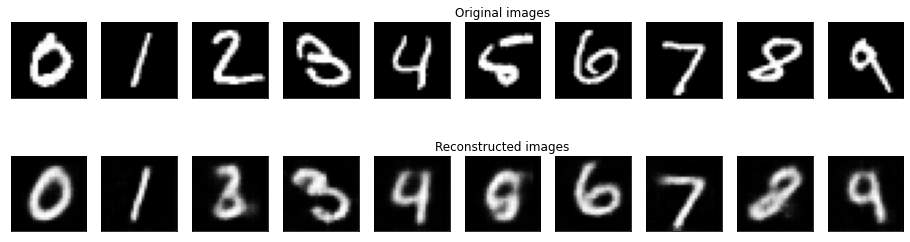

	 partial train loss (single batch): 8360.478516
	 partial train loss (single batch): 8514.767578
	 partial train loss (single batch): 8257.884766
	 partial train loss (single batch): 8466.285156
	 partial train loss (single batch): 8334.806641
	 partial train loss (single batch): 8528.146484
	 partial train loss (single batch): 8564.416992
	 partial train loss (single batch): 8215.536133
	 partial train loss (single batch): 8394.238281
	 partial train loss (single batch): 8383.517578
	 partial train loss (single batch): 8717.223633
	 partial train loss (single batch): 8572.701172
	 partial train loss (single batch): 8408.137695
	 partial train loss (single batch): 8687.733398
	 partial train loss (single batch): 8859.212891
	 partial train loss (single batch): 8015.629883
	 partial train loss (single batch): 8290.437500
	 partial train loss (single batch): 8596.990234
	 partial train loss (single batch): 8824.507812
	 partial train loss (single batch): 8657.617188
	 partial train loss

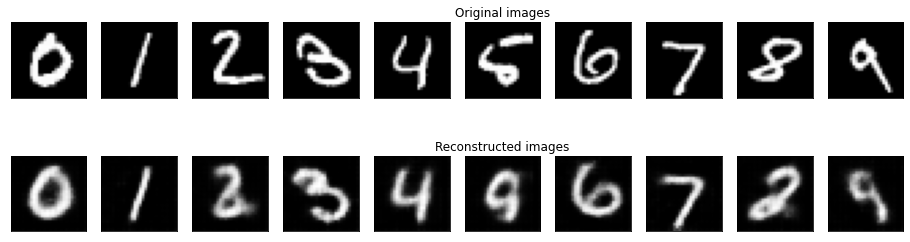

	 partial train loss (single batch): 8323.796875
	 partial train loss (single batch): 8510.925781
	 partial train loss (single batch): 8228.726562
	 partial train loss (single batch): 8433.890625
	 partial train loss (single batch): 8290.093750
	 partial train loss (single batch): 8542.554688
	 partial train loss (single batch): 8517.478516
	 partial train loss (single batch): 8220.589844
	 partial train loss (single batch): 8397.606445
	 partial train loss (single batch): 8443.042969
	 partial train loss (single batch): 8605.599609
	 partial train loss (single batch): 8542.469727
	 partial train loss (single batch): 8431.408203
	 partial train loss (single batch): 8589.181641
	 partial train loss (single batch): 8792.292969
	 partial train loss (single batch): 8054.091797
	 partial train loss (single batch): 8254.853516
	 partial train loss (single batch): 8590.583984
	 partial train loss (single batch): 8855.287109
	 partial train loss (single batch): 8694.971680
	 partial train loss

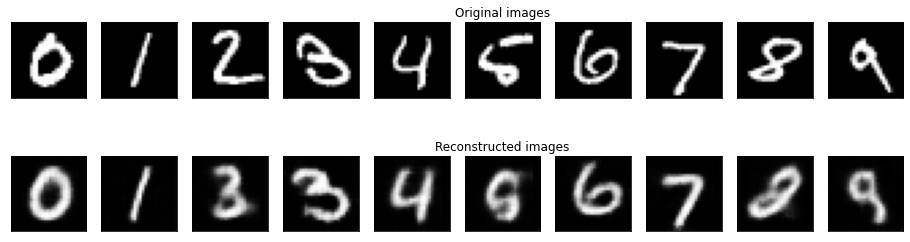

	 partial train loss (single batch): 8313.632812
	 partial train loss (single batch): 8495.605469
	 partial train loss (single batch): 8219.490234
	 partial train loss (single batch): 8409.718750
	 partial train loss (single batch): 8188.513184
	 partial train loss (single batch): 8574.116211
	 partial train loss (single batch): 8528.702148
	 partial train loss (single batch): 8137.568848
	 partial train loss (single batch): 8372.325195
	 partial train loss (single batch): 8347.265625
	 partial train loss (single batch): 8603.842773
	 partial train loss (single batch): 8612.103516
	 partial train loss (single batch): 8295.031250
	 partial train loss (single batch): 8591.162109
	 partial train loss (single batch): 8707.310547
	 partial train loss (single batch): 8059.731445
	 partial train loss (single batch): 8218.710938
	 partial train loss (single batch): 8523.504883
	 partial train loss (single batch): 8816.914062
	 partial train loss (single batch): 8632.442383
	 partial train loss

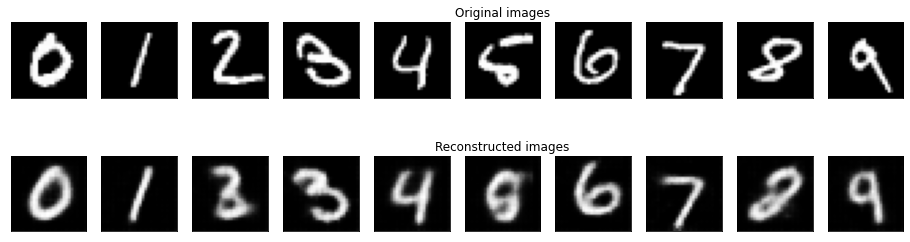

	 partial train loss (single batch): 8399.299805
	 partial train loss (single batch): 8424.988281
	 partial train loss (single batch): 8202.534180
	 partial train loss (single batch): 8391.376953
	 partial train loss (single batch): 8112.690918
	 partial train loss (single batch): 8448.107422
	 partial train loss (single batch): 8501.558594
	 partial train loss (single batch): 8170.919434
	 partial train loss (single batch): 8372.251953
	 partial train loss (single batch): 8315.385742
	 partial train loss (single batch): 8667.589844
	 partial train loss (single batch): 8569.822266
	 partial train loss (single batch): 8374.727539
	 partial train loss (single batch): 8605.791016
	 partial train loss (single batch): 8741.770508
	 partial train loss (single batch): 7990.586914
	 partial train loss (single batch): 8279.791016
	 partial train loss (single batch): 8577.743164
	 partial train loss (single batch): 8763.677734
	 partial train loss (single batch): 8623.218750
	 partial train loss

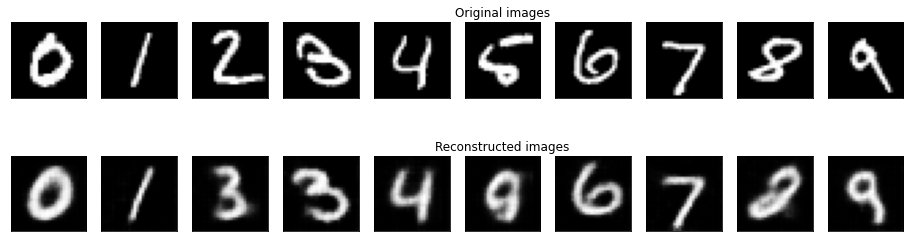

	 partial train loss (single batch): 8375.935547
	 partial train loss (single batch): 8432.496094
	 partial train loss (single batch): 8256.791992
	 partial train loss (single batch): 8381.606445
	 partial train loss (single batch): 8154.333008
	 partial train loss (single batch): 8497.422852
	 partial train loss (single batch): 8491.666992
	 partial train loss (single batch): 8055.989258
	 partial train loss (single batch): 8354.490234
	 partial train loss (single batch): 8295.930664
	 partial train loss (single batch): 8611.624023
	 partial train loss (single batch): 8516.373047
	 partial train loss (single batch): 8283.012695
	 partial train loss (single batch): 8490.927734
	 partial train loss (single batch): 8710.655273
	 partial train loss (single batch): 7927.771484
	 partial train loss (single batch): 8183.216797
	 partial train loss (single batch): 8470.614258
	 partial train loss (single batch): 8699.953125
	 partial train loss (single batch): 8520.871094
	 partial train loss

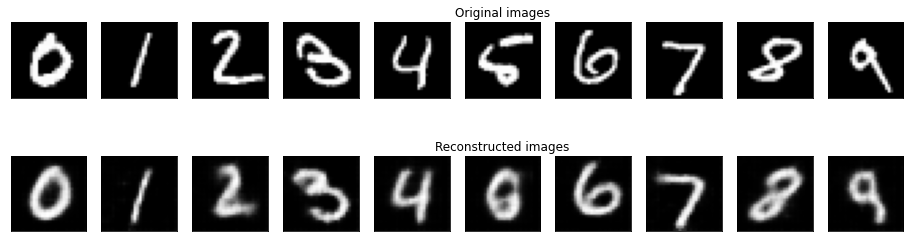

	 partial train loss (single batch): 8311.601562
	 partial train loss (single batch): 8377.287109
	 partial train loss (single batch): 8190.049805
	 partial train loss (single batch): 8390.933594
	 partial train loss (single batch): 8041.889648
	 partial train loss (single batch): 8473.017578
	 partial train loss (single batch): 8484.669922
	 partial train loss (single batch): 8074.047363
	 partial train loss (single batch): 8336.889648
	 partial train loss (single batch): 8261.541016
	 partial train loss (single batch): 8554.969727
	 partial train loss (single batch): 8495.345703
	 partial train loss (single batch): 8250.550781
	 partial train loss (single batch): 8551.997070
	 partial train loss (single batch): 8701.749023
	 partial train loss (single batch): 7943.642578
	 partial train loss (single batch): 8126.866211
	 partial train loss (single batch): 8433.119141
	 partial train loss (single batch): 8745.312500
	 partial train loss (single batch): 8558.650391
	 partial train loss

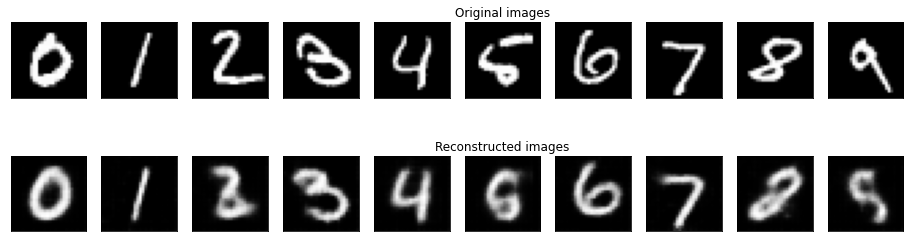

	 partial train loss (single batch): 8311.623047
	 partial train loss (single batch): 8359.258789
	 partial train loss (single batch): 8150.954590
	 partial train loss (single batch): 8379.295898
	 partial train loss (single batch): 8132.783203
	 partial train loss (single batch): 8416.604492
	 partial train loss (single batch): 8446.607422
	 partial train loss (single batch): 8046.561523
	 partial train loss (single batch): 8255.588867
	 partial train loss (single batch): 8261.041016
	 partial train loss (single batch): 8568.416016
	 partial train loss (single batch): 8458.362305
	 partial train loss (single batch): 8311.880859
	 partial train loss (single batch): 8601.439453
	 partial train loss (single batch): 8665.195312
	 partial train loss (single batch): 7906.307617
	 partial train loss (single batch): 8170.708496
	 partial train loss (single batch): 8505.944336
	 partial train loss (single batch): 8688.413086
	 partial train loss (single batch): 8542.610352
	 partial train loss

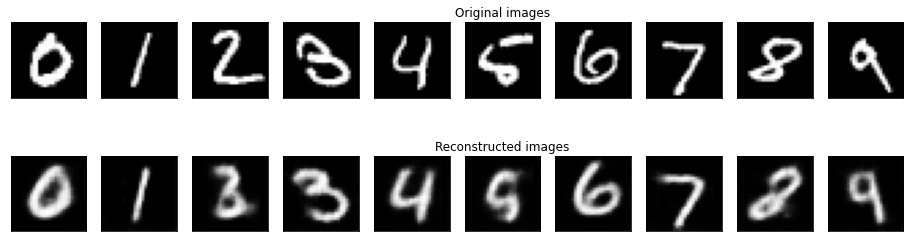

	 partial train loss (single batch): 8289.330078
	 partial train loss (single batch): 8380.168945
	 partial train loss (single batch): 8163.591309
	 partial train loss (single batch): 8285.812500
	 partial train loss (single batch): 8172.637695
	 partial train loss (single batch): 8423.329102
	 partial train loss (single batch): 8461.265625
	 partial train loss (single batch): 8012.282715
	 partial train loss (single batch): 8279.914062
	 partial train loss (single batch): 8214.393555
	 partial train loss (single batch): 8572.406250
	 partial train loss (single batch): 8496.345703
	 partial train loss (single batch): 8273.886719
	 partial train loss (single batch): 8596.978516
	 partial train loss (single batch): 8715.964844
	 partial train loss (single batch): 7924.825684
	 partial train loss (single batch): 8166.255859
	 partial train loss (single batch): 8474.556641
	 partial train loss (single batch): 8659.594727
	 partial train loss (single batch): 8508.792969
	 partial train loss

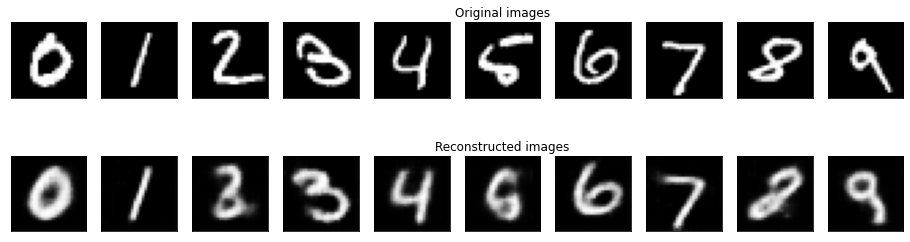

	 partial train loss (single batch): 8337.986328
	 partial train loss (single batch): 8362.463867
	 partial train loss (single batch): 8115.003906
	 partial train loss (single batch): 8304.411133
	 partial train loss (single batch): 8076.424316
	 partial train loss (single batch): 8367.929688
	 partial train loss (single batch): 8432.661133
	 partial train loss (single batch): 8058.335938
	 partial train loss (single batch): 8314.201172
	 partial train loss (single batch): 8197.904297
	 partial train loss (single batch): 8557.441406
	 partial train loss (single batch): 8470.298828
	 partial train loss (single batch): 8262.529297
	 partial train loss (single batch): 8487.842773
	 partial train loss (single batch): 8616.099609
	 partial train loss (single batch): 7937.145508
	 partial train loss (single batch): 8077.536133
	 partial train loss (single batch): 8522.160156
	 partial train loss (single batch): 8733.974609
	 partial train loss (single batch): 8498.927734
	 partial train loss

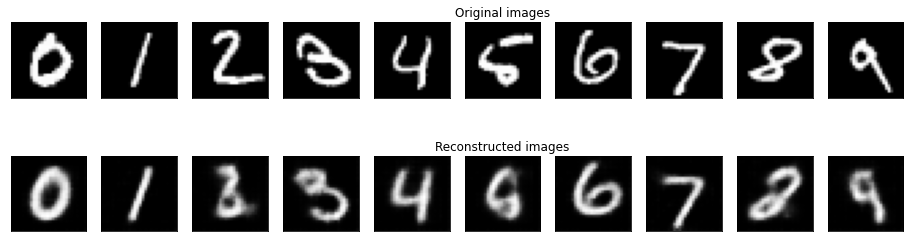

	 partial train loss (single batch): 8274.882812
	 partial train loss (single batch): 8359.369141
	 partial train loss (single batch): 8161.979492
	 partial train loss (single batch): 8289.365234
	 partial train loss (single batch): 8074.246094
	 partial train loss (single batch): 8457.994141
	 partial train loss (single batch): 8417.144531
	 partial train loss (single batch): 8060.341309
	 partial train loss (single batch): 8337.701172
	 partial train loss (single batch): 8142.841797
	 partial train loss (single batch): 8543.076172
	 partial train loss (single batch): 8395.813477
	 partial train loss (single batch): 8151.048828
	 partial train loss (single batch): 8480.939453
	 partial train loss (single batch): 8619.415039
	 partial train loss (single batch): 7933.188965
	 partial train loss (single batch): 8221.469727
	 partial train loss (single batch): 8434.104492
	 partial train loss (single batch): 8722.789062
	 partial train loss (single batch): 8526.771484
	 partial train loss

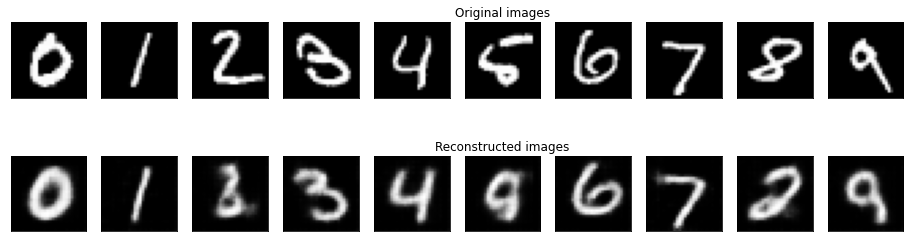

	 partial train loss (single batch): 8239.241211
	 partial train loss (single batch): 8317.527344
	 partial train loss (single batch): 8170.493652
	 partial train loss (single batch): 8270.107422
	 partial train loss (single batch): 8049.171875
	 partial train loss (single batch): 8387.615234
	 partial train loss (single batch): 8402.011719
	 partial train loss (single batch): 8046.050781
	 partial train loss (single batch): 8282.480469
	 partial train loss (single batch): 8212.027344
	 partial train loss (single batch): 8546.570312
	 partial train loss (single batch): 8402.677734
	 partial train loss (single batch): 8203.563477
	 partial train loss (single batch): 8565.703125
	 partial train loss (single batch): 8575.580078
	 partial train loss (single batch): 7933.604004
	 partial train loss (single batch): 8044.966797
	 partial train loss (single batch): 8480.410156
	 partial train loss (single batch): 8689.802734
	 partial train loss (single batch): 8458.742188
	 partial train loss

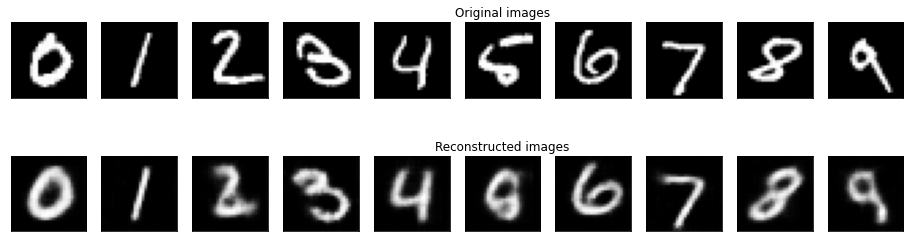

	 partial train loss (single batch): 8239.056641
	 partial train loss (single batch): 8281.658203
	 partial train loss (single batch): 8072.253418
	 partial train loss (single batch): 8334.673828
	 partial train loss (single batch): 8081.989746
	 partial train loss (single batch): 8410.572266
	 partial train loss (single batch): 8407.154297
	 partial train loss (single batch): 8068.113770
	 partial train loss (single batch): 8281.823242
	 partial train loss (single batch): 8201.880859
	 partial train loss (single batch): 8587.162109
	 partial train loss (single batch): 8418.011719
	 partial train loss (single batch): 8240.583984
	 partial train loss (single batch): 8512.832031
	 partial train loss (single batch): 8607.833008
	 partial train loss (single batch): 7856.744141
	 partial train loss (single batch): 8091.252930
	 partial train loss (single batch): 8430.381836
	 partial train loss (single batch): 8758.014648
	 partial train loss (single batch): 8490.279297
	 partial train loss

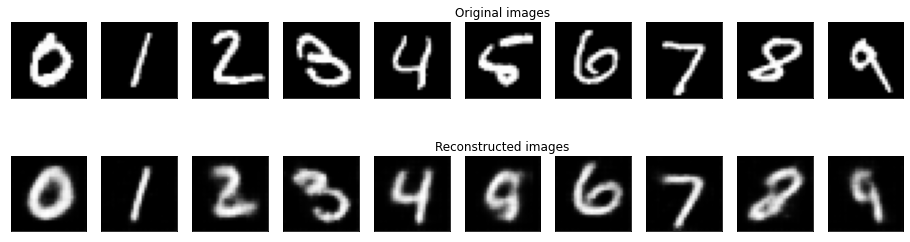

	 partial train loss (single batch): 8216.916992
	 partial train loss (single batch): 8348.161133
	 partial train loss (single batch): 8070.241699
	 partial train loss (single batch): 8301.021484
	 partial train loss (single batch): 8062.555176
	 partial train loss (single batch): 8364.854492
	 partial train loss (single batch): 8382.098633
	 partial train loss (single batch): 8020.333008
	 partial train loss (single batch): 8238.743164
	 partial train loss (single batch): 8129.346680
	 partial train loss (single batch): 8592.529297
	 partial train loss (single batch): 8433.696289
	 partial train loss (single batch): 8173.588867
	 partial train loss (single batch): 8550.226562
	 partial train loss (single batch): 8517.884766
	 partial train loss (single batch): 7973.839355
	 partial train loss (single batch): 8097.603516
	 partial train loss (single batch): 8428.106445
	 partial train loss (single batch): 8682.185547
	 partial train loss (single batch): 8505.802734
	 partial train loss

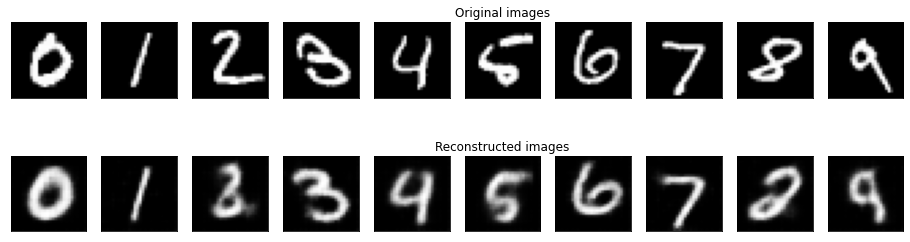

	 partial train loss (single batch): 8218.173828
	 partial train loss (single batch): 8276.267578
	 partial train loss (single batch): 8091.649414
	 partial train loss (single batch): 8256.337891
	 partial train loss (single batch): 7972.821289
	 partial train loss (single batch): 8324.472656
	 partial train loss (single batch): 8307.851562
	 partial train loss (single batch): 8011.016113
	 partial train loss (single batch): 8251.697266
	 partial train loss (single batch): 8139.625000
	 partial train loss (single batch): 8494.712891
	 partial train loss (single batch): 8375.992188
	 partial train loss (single batch): 8176.288086
	 partial train loss (single batch): 8457.780273
	 partial train loss (single batch): 8555.822266
	 partial train loss (single batch): 7890.359375
	 partial train loss (single batch): 8101.606445
	 partial train loss (single batch): 8385.676758
	 partial train loss (single batch): 8713.367188
	 partial train loss (single batch): 8383.035156
	 partial train loss

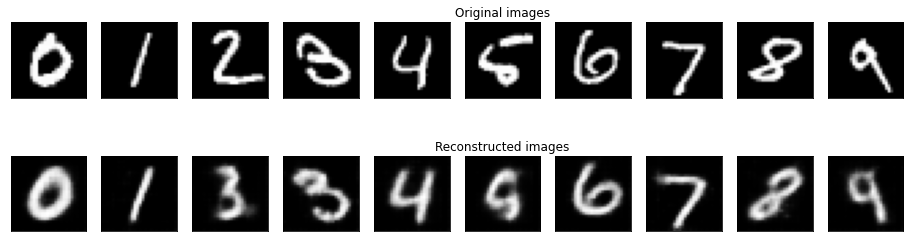

	 partial train loss (single batch): 8244.218750
	 partial train loss (single batch): 8270.443359
	 partial train loss (single batch): 8111.296875
	 partial train loss (single batch): 8232.823242
	 partial train loss (single batch): 8047.208984
	 partial train loss (single batch): 8378.400391
	 partial train loss (single batch): 8361.496094
	 partial train loss (single batch): 8019.506836
	 partial train loss (single batch): 8191.259766
	 partial train loss (single batch): 8139.365234
	 partial train loss (single batch): 8476.827148
	 partial train loss (single batch): 8395.691406
	 partial train loss (single batch): 8213.665039
	 partial train loss (single batch): 8541.261719
	 partial train loss (single batch): 8560.235352
	 partial train loss (single batch): 7828.351074
	 partial train loss (single batch): 8064.734863
	 partial train loss (single batch): 8323.783203
	 partial train loss (single batch): 8657.701172
	 partial train loss (single batch): 8459.457031
	 partial train loss

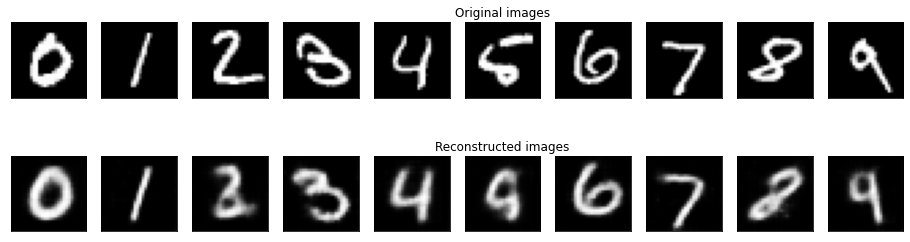

	 partial train loss (single batch): 8176.143066
	 partial train loss (single batch): 8281.250000
	 partial train loss (single batch): 8058.272461
	 partial train loss (single batch): 8269.074219
	 partial train loss (single batch): 7972.455078
	 partial train loss (single batch): 8303.728516
	 partial train loss (single batch): 8373.855469
	 partial train loss (single batch): 7974.439941
	 partial train loss (single batch): 8185.441406
	 partial train loss (single batch): 8100.524902
	 partial train loss (single batch): 8443.263672
	 partial train loss (single batch): 8470.935547
	 partial train loss (single batch): 8157.981445
	 partial train loss (single batch): 8428.864258
	 partial train loss (single batch): 8520.980469
	 partial train loss (single batch): 7796.848633
	 partial train loss (single batch): 8078.935059
	 partial train loss (single batch): 8299.607422
	 partial train loss (single batch): 8618.097656
	 partial train loss (single batch): 8416.597656
	 partial train loss

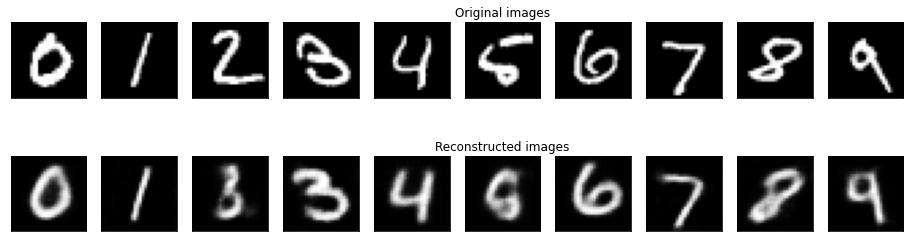

	 partial train loss (single batch): 8190.284180
	 partial train loss (single batch): 8281.874023
	 partial train loss (single batch): 8023.679199
	 partial train loss (single batch): 8276.703125
	 partial train loss (single batch): 8048.625000
	 partial train loss (single batch): 8299.636719
	 partial train loss (single batch): 8340.912109
	 partial train loss (single batch): 7973.053223
	 partial train loss (single batch): 8241.338867
	 partial train loss (single batch): 8167.797363
	 partial train loss (single batch): 8422.837891
	 partial train loss (single batch): 8347.730469
	 partial train loss (single batch): 8185.999512
	 partial train loss (single batch): 8439.003906
	 partial train loss (single batch): 8493.045898
	 partial train loss (single batch): 7833.479980
	 partial train loss (single batch): 8107.582031
	 partial train loss (single batch): 8340.958984
	 partial train loss (single batch): 8571.678711
	 partial train loss (single batch): 8404.502930
	 partial train loss

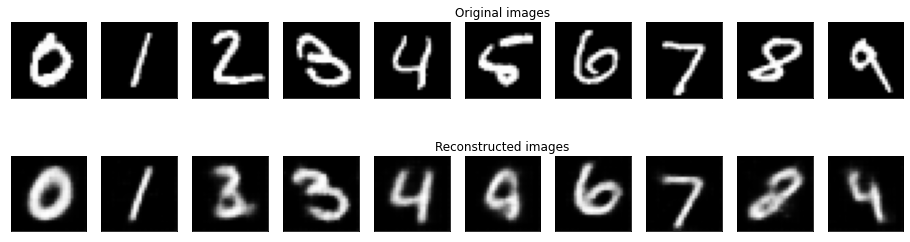

	 partial train loss (single batch): 8167.489258
	 partial train loss (single batch): 8264.634766
	 partial train loss (single batch): 8055.080078
	 partial train loss (single batch): 8311.813477
	 partial train loss (single batch): 8011.208984
	 partial train loss (single batch): 8334.787109
	 partial train loss (single batch): 8385.050781
	 partial train loss (single batch): 7974.034668
	 partial train loss (single batch): 8229.785156
	 partial train loss (single batch): 8151.518555
	 partial train loss (single batch): 8460.757812
	 partial train loss (single batch): 8310.230469
	 partial train loss (single batch): 8113.751953
	 partial train loss (single batch): 8511.067383
	 partial train loss (single batch): 8586.746094
	 partial train loss (single batch): 7873.151855
	 partial train loss (single batch): 8033.293945
	 partial train loss (single batch): 8307.423828
	 partial train loss (single batch): 8658.263672
	 partial train loss (single batch): 8397.416992
	 partial train loss

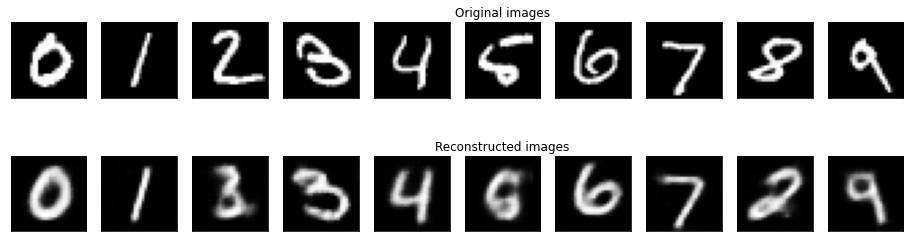

	 partial train loss (single batch): 8150.706055
	 partial train loss (single batch): 8258.847656
	 partial train loss (single batch): 8028.326172
	 partial train loss (single batch): 8169.473145
	 partial train loss (single batch): 8125.178711
	 partial train loss (single batch): 8327.731445
	 partial train loss (single batch): 8302.216797
	 partial train loss (single batch): 7927.413574
	 partial train loss (single batch): 8197.848633
	 partial train loss (single batch): 8016.366699
	 partial train loss (single batch): 8461.308594
	 partial train loss (single batch): 8316.248047
	 partial train loss (single batch): 8151.006836
	 partial train loss (single batch): 8446.715820
	 partial train loss (single batch): 8523.839844
	 partial train loss (single batch): 7860.777344
	 partial train loss (single batch): 8085.520020
	 partial train loss (single batch): 8348.113281
	 partial train loss (single batch): 8605.438477
	 partial train loss (single batch): 8374.757812
	 partial train loss

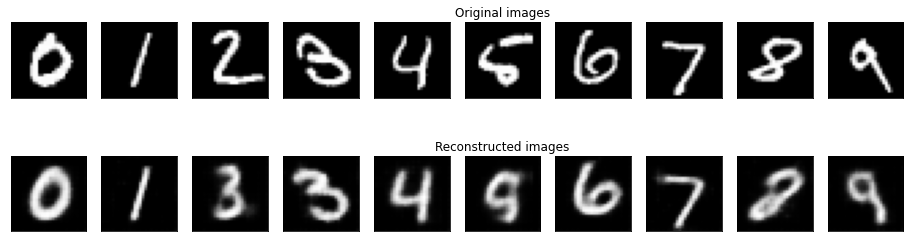

	 partial train loss (single batch): 8207.665039
	 partial train loss (single batch): 8259.385742
	 partial train loss (single batch): 8003.774414
	 partial train loss (single batch): 8310.947266
	 partial train loss (single batch): 8015.138672
	 partial train loss (single batch): 8297.212891
	 partial train loss (single batch): 8327.056641
	 partial train loss (single batch): 7887.633301
	 partial train loss (single batch): 8165.314941
	 partial train loss (single batch): 8085.588867
	 partial train loss (single batch): 8374.960938
	 partial train loss (single batch): 8334.930664
	 partial train loss (single batch): 8188.136230
	 partial train loss (single batch): 8388.864258
	 partial train loss (single batch): 8519.963867
	 partial train loss (single batch): 7837.791016
	 partial train loss (single batch): 8031.177734
	 partial train loss (single batch): 8294.878906
	 partial train loss (single batch): 8591.284180
	 partial train loss (single batch): 8440.042969
	 partial train loss

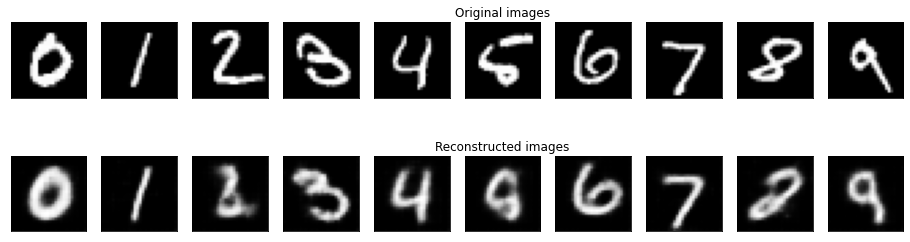

	 partial train loss (single batch): 8210.722656
	 partial train loss (single batch): 8241.750977
	 partial train loss (single batch): 8032.940430
	 partial train loss (single batch): 8168.869629
	 partial train loss (single batch): 8017.017090
	 partial train loss (single batch): 8303.560547
	 partial train loss (single batch): 8311.359375
	 partial train loss (single batch): 7918.220703
	 partial train loss (single batch): 8154.124512
	 partial train loss (single batch): 8092.384766
	 partial train loss (single batch): 8467.176758
	 partial train loss (single batch): 8338.791992
	 partial train loss (single batch): 8160.683594
	 partial train loss (single batch): 8398.593750
	 partial train loss (single batch): 8496.194336
	 partial train loss (single batch): 7819.121582
	 partial train loss (single batch): 8035.002930
	 partial train loss (single batch): 8274.061523
	 partial train loss (single batch): 8631.335938
	 partial train loss (single batch): 8348.667969
	 partial train loss

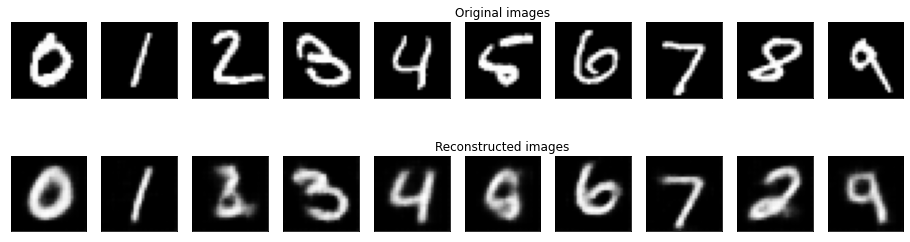

	 partial train loss (single batch): 8163.637207
	 partial train loss (single batch): 8187.784668
	 partial train loss (single batch): 8061.791992
	 partial train loss (single batch): 8190.094238
	 partial train loss (single batch): 8099.845703
	 partial train loss (single batch): 8318.759766
	 partial train loss (single batch): 8293.107422
	 partial train loss (single batch): 7894.807617
	 partial train loss (single batch): 8166.764648
	 partial train loss (single batch): 8041.299805
	 partial train loss (single batch): 8421.486328
	 partial train loss (single batch): 8255.172852
	 partial train loss (single batch): 8120.518066
	 partial train loss (single batch): 8447.560547
	 partial train loss (single batch): 8452.531250
	 partial train loss (single batch): 7846.374512
	 partial train loss (single batch): 7977.142090
	 partial train loss (single batch): 8361.333984
	 partial train loss (single batch): 8568.879883
	 partial train loss (single batch): 8369.837891
	 partial train loss

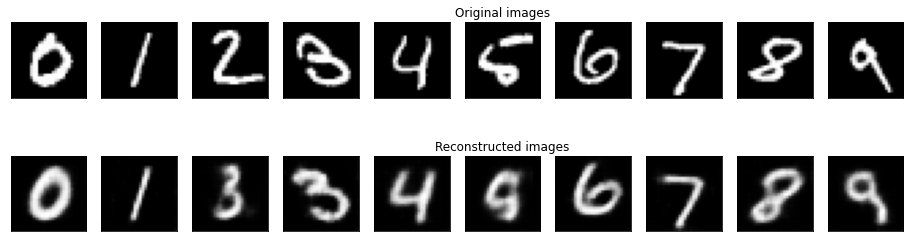

	 partial train loss (single batch): 8190.082031
	 partial train loss (single batch): 8186.607910
	 partial train loss (single batch): 7996.002441
	 partial train loss (single batch): 8222.171875
	 partial train loss (single batch): 7969.437988
	 partial train loss (single batch): 8314.126953
	 partial train loss (single batch): 8222.806641
	 partial train loss (single batch): 7906.375977
	 partial train loss (single batch): 8232.501953
	 partial train loss (single batch): 8052.381836
	 partial train loss (single batch): 8363.485352
	 partial train loss (single batch): 8372.185547
	 partial train loss (single batch): 8097.079102
	 partial train loss (single batch): 8399.879883
	 partial train loss (single batch): 8462.219727
	 partial train loss (single batch): 7713.778809
	 partial train loss (single batch): 7986.084473
	 partial train loss (single batch): 8306.509766
	 partial train loss (single batch): 8643.083984
	 partial train loss (single batch): 8300.970703
	 partial train loss

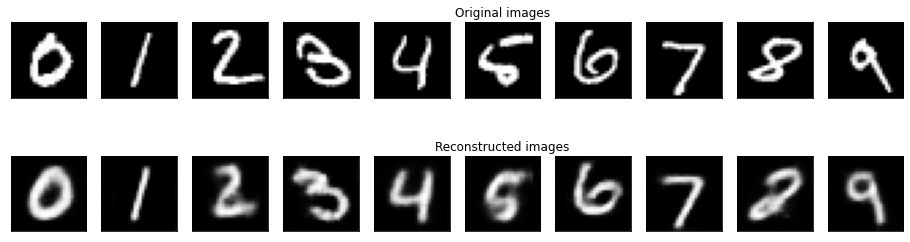

	 partial train loss (single batch): 8095.208008
	 partial train loss (single batch): 8219.940430
	 partial train loss (single batch): 8057.703613
	 partial train loss (single batch): 8211.000000
	 partial train loss (single batch): 8009.875000
	 partial train loss (single batch): 8240.087891
	 partial train loss (single batch): 8345.189453
	 partial train loss (single batch): 7903.966797
	 partial train loss (single batch): 8213.044922
	 partial train loss (single batch): 7986.578125
	 partial train loss (single batch): 8403.839844
	 partial train loss (single batch): 8305.847656
	 partial train loss (single batch): 8081.316406
	 partial train loss (single batch): 8414.662109
	 partial train loss (single batch): 8447.140625
	 partial train loss (single batch): 7818.852539
	 partial train loss (single batch): 8005.655762
	 partial train loss (single batch): 8299.966797
	 partial train loss (single batch): 8533.419922
	 partial train loss (single batch): 8334.476562
	 partial train loss

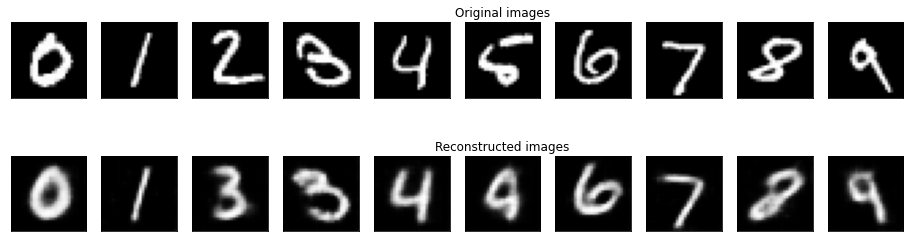

	 partial train loss (single batch): 8073.290039
	 partial train loss (single batch): 8263.801758
	 partial train loss (single batch): 8008.908203
	 partial train loss (single batch): 8134.725098
	 partial train loss (single batch): 7974.355469
	 partial train loss (single batch): 8364.935547
	 partial train loss (single batch): 8321.359375
	 partial train loss (single batch): 7871.426758
	 partial train loss (single batch): 8135.516602
	 partial train loss (single batch): 8002.203125
	 partial train loss (single batch): 8418.755859
	 partial train loss (single batch): 8261.237305
	 partial train loss (single batch): 8126.141602
	 partial train loss (single batch): 8407.929688
	 partial train loss (single batch): 8471.988281
	 partial train loss (single batch): 7829.188965
	 partial train loss (single batch): 8006.975586
	 partial train loss (single batch): 8193.955078
	 partial train loss (single batch): 8601.066406
	 partial train loss (single batch): 8299.504883
	 partial train loss

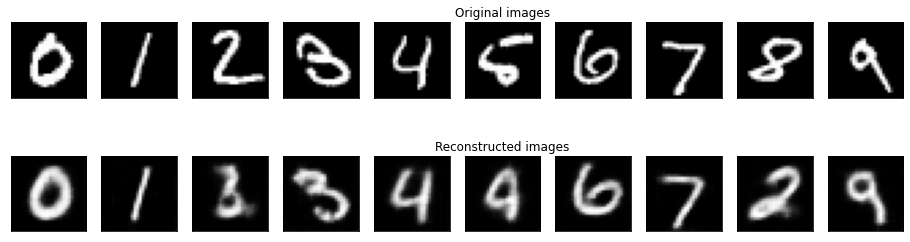

	 partial train loss (single batch): 8168.364746
	 partial train loss (single batch): 8194.216797
	 partial train loss (single batch): 7982.941406
	 partial train loss (single batch): 8145.781250
	 partial train loss (single batch): 7922.221680
	 partial train loss (single batch): 8261.739258
	 partial train loss (single batch): 8240.559570
	 partial train loss (single batch): 7891.811523
	 partial train loss (single batch): 8151.815918
	 partial train loss (single batch): 8049.056641
	 partial train loss (single batch): 8436.795898
	 partial train loss (single batch): 8294.760742
	 partial train loss (single batch): 8108.366211
	 partial train loss (single batch): 8415.041992
	 partial train loss (single batch): 8492.603516
	 partial train loss (single batch): 7832.982422
	 partial train loss (single batch): 7972.526855
	 partial train loss (single batch): 8349.904297
	 partial train loss (single batch): 8626.060547
	 partial train loss (single batch): 8318.591797
	 partial train loss

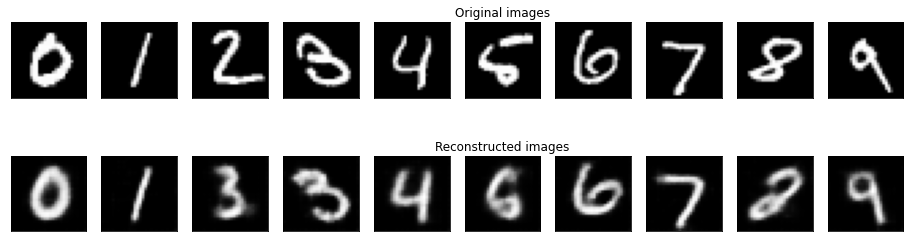

	 partial train loss (single batch): 8118.497070
	 partial train loss (single batch): 8102.478516
	 partial train loss (single batch): 7989.726074
	 partial train loss (single batch): 8151.983398
	 partial train loss (single batch): 8000.625488
	 partial train loss (single batch): 8228.293945
	 partial train loss (single batch): 8227.516602
	 partial train loss (single batch): 7951.794922
	 partial train loss (single batch): 8169.161621
	 partial train loss (single batch): 8085.583496
	 partial train loss (single batch): 8387.381836
	 partial train loss (single batch): 8310.751953
	 partial train loss (single batch): 8078.519531
	 partial train loss (single batch): 8369.768555
	 partial train loss (single batch): 8417.623047
	 partial train loss (single batch): 7832.688477
	 partial train loss (single batch): 8010.198730
	 partial train loss (single batch): 8321.725586
	 partial train loss (single batch): 8556.035156
	 partial train loss (single batch): 8370.819336
	 partial train loss

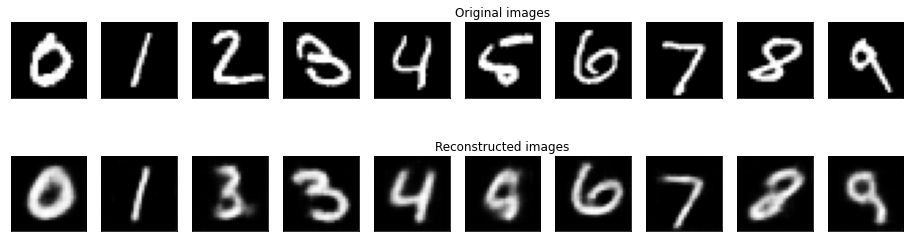

	 partial train loss (single batch): 8125.369141
	 partial train loss (single batch): 8238.034180
	 partial train loss (single batch): 7992.864258
	 partial train loss (single batch): 8167.389648
	 partial train loss (single batch): 7979.658203
	 partial train loss (single batch): 8210.441406
	 partial train loss (single batch): 8304.208008
	 partial train loss (single batch): 7994.754883
	 partial train loss (single batch): 8140.304199
	 partial train loss (single batch): 8038.042969
	 partial train loss (single batch): 8344.462891
	 partial train loss (single batch): 8307.417969
	 partial train loss (single batch): 8098.108398
	 partial train loss (single batch): 8419.634766
	 partial train loss (single batch): 8441.138672
	 partial train loss (single batch): 7841.199219
	 partial train loss (single batch): 8047.367676
	 partial train loss (single batch): 8335.834961
	 partial train loss (single batch): 8573.377930
	 partial train loss (single batch): 8311.917969
	 partial train loss

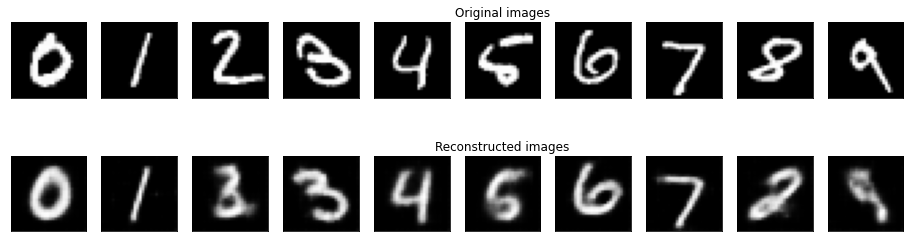

	 partial train loss (single batch): 8128.578125
	 partial train loss (single batch): 8141.104004
	 partial train loss (single batch): 7934.212402
	 partial train loss (single batch): 8165.759766
	 partial train loss (single batch): 7987.347656
	 partial train loss (single batch): 8251.673828
	 partial train loss (single batch): 8222.337891
	 partial train loss (single batch): 7810.002930
	 partial train loss (single batch): 8170.760742
	 partial train loss (single batch): 7966.957520
	 partial train loss (single batch): 8247.046875
	 partial train loss (single batch): 8236.111328
	 partial train loss (single batch): 8022.280273
	 partial train loss (single batch): 8294.457031
	 partial train loss (single batch): 8453.955078
	 partial train loss (single batch): 7882.914551
	 partial train loss (single batch): 7943.595703
	 partial train loss (single batch): 8421.519531
	 partial train loss (single batch): 8515.654297
	 partial train loss (single batch): 8315.340820
	 partial train loss

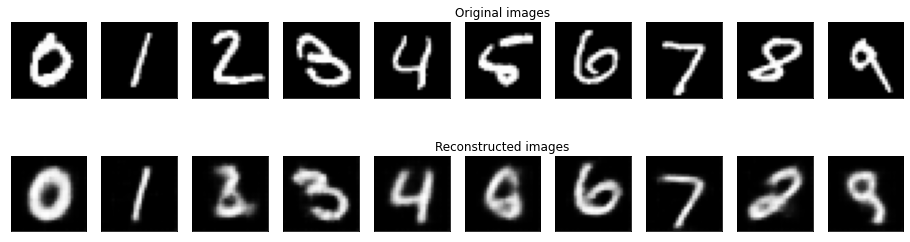

	 partial train loss (single batch): 8169.889648
	 partial train loss (single batch): 8061.870117
	 partial train loss (single batch): 7941.566895
	 partial train loss (single batch): 8174.388184
	 partial train loss (single batch): 8005.100586
	 partial train loss (single batch): 8296.473633
	 partial train loss (single batch): 8276.448242
	 partial train loss (single batch): 7873.593750
	 partial train loss (single batch): 8074.938477
	 partial train loss (single batch): 8023.457031
	 partial train loss (single batch): 8345.171875
	 partial train loss (single batch): 8239.032227
	 partial train loss (single batch): 8019.892578
	 partial train loss (single batch): 8342.212891
	 partial train loss (single batch): 8380.839844
	 partial train loss (single batch): 7741.135254
	 partial train loss (single batch): 7957.075195
	 partial train loss (single batch): 8262.969727
	 partial train loss (single batch): 8566.237305
	 partial train loss (single batch): 8303.528320
	 partial train loss

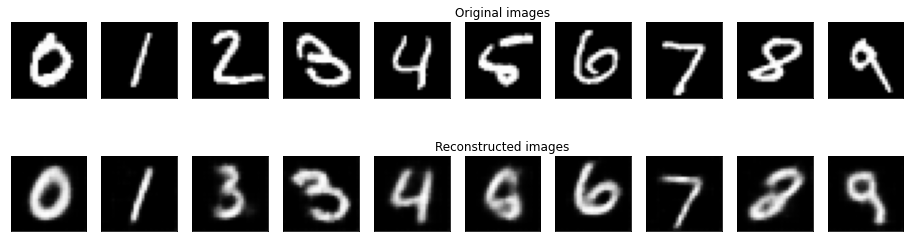

	 partial train loss (single batch): 8063.831543
	 partial train loss (single batch): 8199.800781
	 partial train loss (single batch): 7991.068848
	 partial train loss (single batch): 8150.287109
	 partial train loss (single batch): 8034.228516
	 partial train loss (single batch): 8154.772461
	 partial train loss (single batch): 8203.839844
	 partial train loss (single batch): 7928.557129
	 partial train loss (single batch): 8097.797852
	 partial train loss (single batch): 8076.602539
	 partial train loss (single batch): 8337.494141
	 partial train loss (single batch): 8271.673828
	 partial train loss (single batch): 8020.777344
	 partial train loss (single batch): 8399.212891
	 partial train loss (single batch): 8447.480469
	 partial train loss (single batch): 7769.912598
	 partial train loss (single batch): 7995.673828
	 partial train loss (single batch): 8213.656250
	 partial train loss (single batch): 8604.687500
	 partial train loss (single batch): 8277.960938
	 partial train loss

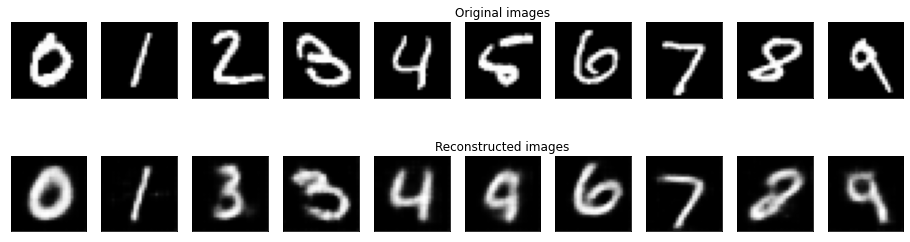

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   plot_ae_outputs(vae.encoder,vae.decoder,n=10)

## Testing 

In [ ]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

In [ ]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img  = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)


In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()